In [201]:
import pandas as pd
import numpy as np
import tqdm
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import GridSearchCV
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.naive_bayes        import GaussianNB
from sklearn.svm import SVC, LinearSVC 
from sklearn.model_selection import cross_val_score, KFold
train = pd.read_parquet('/Users/tessergey/Downloads/lab1/train.parquet', engine='fastparquet')
raw_train = pd.read_parquet('/Users/tessergey/Downloads/lab1/train.parquet', engine='fastparquet')
test = pd.read_parquet('/Users/tessergey/Downloads/lab1/test.parquet', engine='fastparquet')

# Part 1 

## EDA

### Статистики данных

In [202]:
train.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [203]:
train.shape 

(48000, 4)

In [204]:
train.info

<bound method DataFrame.info of                                                        Body  \
Id                                                            
34862324  Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...   
47303682  While converting the data frame to HTML, Date ...   
46431243  <p>This should be an easy one, but somehow I c...   
45306324  <p>Let say I have a component in Angular 2 tha...   
49479547  <p>I'm setting a var using \n<code>set TEST_VA...   
...                                                     ...   
35488105  <p>Aspx Webpage accepting value in DD/mm/yyyy ...   
37045803  <p>I am making a program in C#. I want it to d...   
43601747  <p>The <a href="https://kafka.apache.org/0100/...   
40505904  <p>Using the new pull request approval process...   
40415937  i have taken three arrays one Array for saving...   

                                                 Tags  \
Id                                                      
34862324           <java><algorith

In [205]:
train.columns

Index(['Body', 'Tags', 'Title', 'target'], dtype='object')

Уже здесь можно увидеть что значения target разделены на равные доли 

In [206]:
train.describe()

,target
count,48000.000000
mean,1.000000
std,0.816505
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Можно заметить что в столбике target у нас нет NaN значений 

In [207]:
train.target.value_counts()

2    16000
1    16000
0    16000
Name: target, dtype: int64

In [208]:
# в процентном соотношении 
train.target.value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: target, dtype: float64

Проверка анализируемых типов данных

In [209]:
train.dtypes

Body      object
Tags      object
Title     object
target     int64
dtype: object

Определение языка. Чтобы убедится, что в дальнейшем мы работает именно с тем языком 

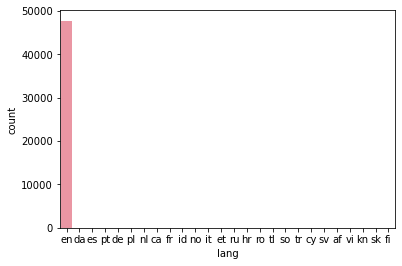

In [211]:
import langdetect 
txt = raw_train["Body"].iloc[0]
raw_train['lang'] = raw_train["Body"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
#raw_train.head()
sns.countplot(x = 'lang', data=raw_train)

Пропущенные значения

In [212]:
# Количество NaN значений
train.isna().sum()

Body      0
Tags      0
Title     0
target    0
dtype: int64

In [213]:
# any показывает есть ли хотя бы одно nan в столбце 
train.isna().any()

Body      False
Tags      False
Title     False
target    False
dtype: bool

### Перобразование и  Очистка мусора

In [214]:
#Создание нового столбца text, который объединил три остальных текстовых столбца 
train["text"] = train["Tags"] + " " + train["Title"] + " " + train["Body"]
#Удаление ненужных уже столбцов
train.drop(['Tags','Title','Body'], axis = 1, inplace = True)

In [215]:
#Приведение всех букв к нижнему регистру 
train["text"] = train["text"].str.lower()
train.head()

,target,text
Id,,
34862324,2,<java><algorithm><graph-algorithm> i am implem...
47303682,2,<html><r><dataframe> r studio: date is getting...
46431243,0,<python><pandas><dataframe><pandas-groupby> pa...
45306324,0,<angular><typescript><rxjs> casting results fr...
49479547,1,<c><windows><batch-file> environment variable ...


In [216]:
#Отчистка специальных знаков и знаков пунктуации 
import re
def preprocess(whole_text, with_dots):
    if with_dots == True:
        whole_text = re.sub(r'[^(a-zA-Z.)\s]',' ', whole_text)
    else:
        whole_text = re.sub(r'[^(a-zA-Z)\s]',' ', whole_text)
    whole_text = re.sub(' +', ' ', whole_text)
    return whole_text

train["text"] = train["text"].apply(preprocess, with_dots = True)
train["text"] = train["text"].apply(preprocess, with_dots = False)
train.head()

,target,text
Id,,
34862324,2,java algorithm graph algorithm i am implement...
47303682,2,html r dataframe r studio date is getting con...
46431243,0,python pandas dataframe pandas groupby pandas...
45306324,0,angular typescript rxjs casting results from ...
49479547,1,c windows batch file environment variable set...


In [218]:
print(train["text"].iloc[1])

 html r dataframe r studio date is getting converted to number while making html of datafrane while converting the data frame to html date is getting converted to a number 

how to keep it date only 


In [219]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize   
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/tessergey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tessergey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tessergey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Лемантизация. Стемминг не использовался, хотелось сохранить смысл слов

In [220]:
 import spacy
spacyEnglishObject = spacy.load('en', disable=['parser', 'ner'])

#Функция которая лемнтизирует предложение 
def preprocess_sentence(sentence):
    parsedSentence = spacyEnglishObject(sentence)
    filtered_sentence = " ".join([token.lemma_ for token in parsedSentence])
    return filtered_sentence

In [221]:
#Применение функции к каждой строке
train['text'] = train['text'].apply(lambda x: preprocess_sentence(x))
train.head()

,target,text
Id,,
34862324,2,java algorithm graph algorithm i be implemen...
47303682,2,html r dataframe r studio date be get conver...
46431243,0,python pandas dataframe pandas groupby panda...
45306324,0,angular typescript rxjs cast result from obs...
49479547,1,c window batch file environment variable set...


NER (Named-entity recognition)

In [223]:
ner =  spacy.load('en') 
ners = raw_train["Body"][:100].apply(lambda x: [(tag.text,tag.label_) 
                                for tag in ner(x).ents] )
print(ners)

Id
34862324                                                   []
47303682                        [(HTML, ORG), (Date, PERSON)]
46431243    [(pre><code, ORG), (col4, DATE), (0, CARDINAL)...
45306324    [(Angular, ORG), (2, CARDINAL), (one, CARDINAL...
49479547                                                   []
                                  ...                        
39718268    [(C++, DATE), (#88, CARDINAL), (Most Important...
36084902    [(SELECT, WORK_OF_ART), (max min, PERSON), (ye...
34769673    [(Ruby, ORG), (Windows, PRODUCT), (mac, ORG), ...
36918701                        [(123, CARDINAL), (abc, ORG)]
38223882      [(Jack, PERSON), (8, CARDINAL), (jack, PERSON)]
Name: Body, Length: 100, dtype: object


### Визуализация

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

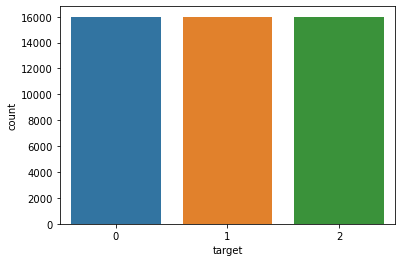

In [225]:
# количество значений в столбце target 
sns.countplot(x = 'target', data=train)

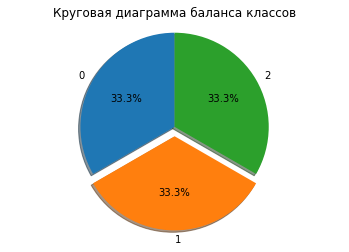

In [226]:
labels = ['0', '1', '2']
sizes = [0,0,0]
target = train["target"].to_numpy()
for i in range(len(target)):
  sizes[target[i]] += 1
explode = (0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Круговая диаграмма баланса классов")
plt.show()

In [227]:
# Через две вышепредставленных диаграммы мы можем сказать, что данные идеально сбалансированы
# Каждый класс (target) имеет равное количество значений

In [228]:
def print_word_clouds(df, class_target, with_stop_words, list_stop_words):
    plt.figure(figsize=(10,10))
    if with_stop_words == True:
            if class_target == -1:
                wordcloud = WordCloud(stopwords=list_stop_words,background_color="white",max_words=800).generate(" ".join(df.text))
            else:
                wordcloud = WordCloud(stopwords=list_stop_words,background_color="white",max_words=800).generate(" ".join(df[df['target'] == class_target].text))
    else:
            if class_target == -1:
                wordcloud = WordCloud(background_color="white",max_words=800).generate(" ".join(df.text))
            else:
                wordcloud = WordCloud(background_color="white",max_words=800).generate(" ".join(df[df['target'] == class_target].text))
    plt.imshow(wordcloud , interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

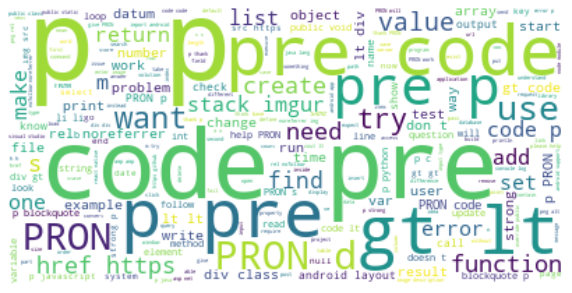

In [229]:
# Чтобы увидеть наиболее часто встречающиеся слова, построим wordclouds для всего текста и отдельных классов
print_word_clouds(train, -1, False, [])

In [230]:
# Как можно заметить, сейчас здесь очень много слов, которые, на наш взгляд, не несут смысла, а только загрязняют данные 
# Добавим эти слова в список Stopwords и исключим из выборки 
myStopList = set(STOPWORDS)
myStopList.update(["p", "div", "-PRON-", "gt", "t", "td", "lt"])

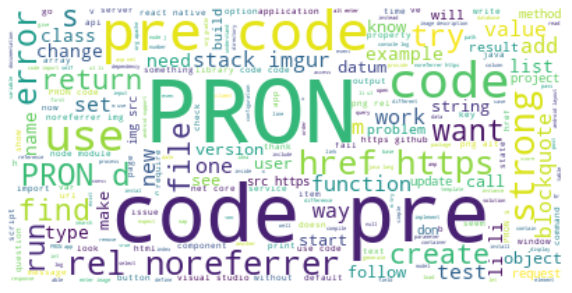

In [231]:
print_word_clouds(train, 0, True, myStopList)

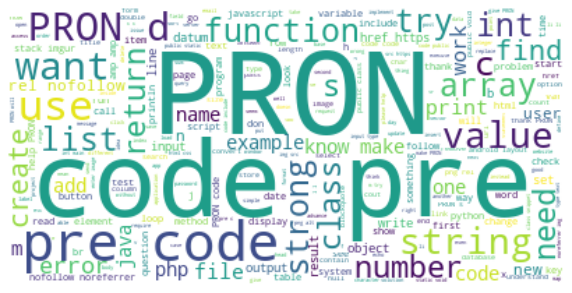

In [232]:
print_word_clouds(train, 1, True, myStopList)

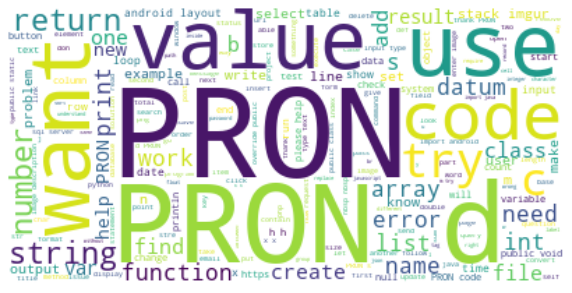

In [233]:
print_word_clouds(train, 2, True, myStopList)

In [234]:
#remove stop words
def remove_stop_words(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = ' '.join([w for w in word_tokens if w not in myStopList])
    return filtered_sentence

In [235]:
train["text"] = train["text"].apply(lambda x: remove_stop_words(x))

In [236]:
#train.head()

,target,text
Id,,
34862324,2,java algorithm graph algorithm implement minim...
47303682,2,html dataframe studio date convert number make...
46431243,0,python pandas dataframe pandas groupby pandas ...
45306324,0,angular typescript rxjs cast result observable...
49479547,1,c window batch file environment variable set b...


На этом работа по анализу и подготовке данных закончена, сохраним результат в файл для дальнейшей работы с ним 

In [237]:
train.to_csv('train_clear.csv', index=True)

In [200]:
#print(train["text"].iloc[0])

In [238]:
def count_number_tag(data):
  tags = dict()
  for i, row in tqdm.tqdm(data.iterrows()):
    
    current_tags = row["Tags"].split("<")
    for j in range(1,len(current_tags)):
      if current_tags[j][:-1] in tags:
        tags[current_tags[j][:-1]] += 1
      else:
        tags[current_tags[j][:-1]] = 1
  return tags


def create_most_popular_tags(data, number_of_tags):
  most_popul_tags = dict()
  most_popul_tags = {k: v for k, v in reversed(sorted(data.items(), key=lambda item: item[1]))}
  labels = list()
  values = list()
  for i in range(len(most_popul_tags)):
    labels.append(list(most_popul_tags.keys())[i])
    values.append(most_popul_tags[list(most_popul_tags.keys())[i]])
    if i == number_of_tags:
      break
  return labels, values


def plot_most_popular_tags(labels, values, name):
  x = np.arange(len(labels))
  width = 0.35

  fig, ax = plt.subplots(figsize=(30, 8))
  rects1 = ax.bar(x - width/2, values, width, label=name)

  ax.set_ylabel('Number of questions')
  ax.set_xlabel('Tags')

  ax.set_title('30 most popular question tag')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.show()
  pass

48000it [00:04, 11435.50it/s]


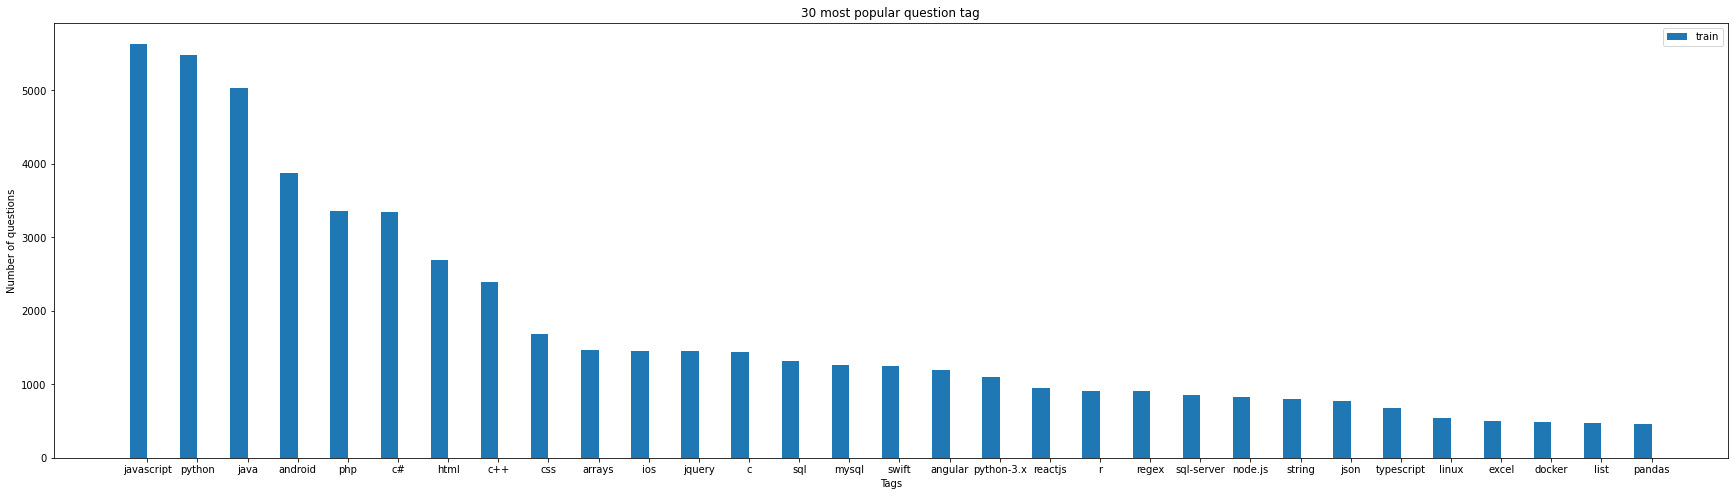

In [239]:
number_of_tags = 30
train_tags = count_number_tag(raw_train)
train_labels, train_values = create_most_popular_tags(train_tags, number_of_tags)
plot_most_popular_tags(train_labels, train_values, name="train")

### Features

In [240]:
def create_meta_features(dataset, name):
  ## Number of words in the text ##
  dataset["num_words"+name] = dataset["Body"].apply(lambda x: len(str(x).split()))

  ## Number of unique words in the text ##
  dataset["num_unique_words"+name] = dataset["Body"].apply(lambda x: len(set(str(x).split())))

  ## Number of characters in the text ##
  dataset["num_chars"+name] = dataset["Body"].apply(lambda x: len(str(x)))

  ## Number of stopwords in the text ##
  dataset["num_stopwords"+name] = dataset["Body"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

  ## Number of punctuations in the text ##
  dataset["num_punctuations"+name] =dataset['Body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

  ## Number of title case words in the text ##
  dataset["num_words_upper"+name] = dataset["Body"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

  ## Number of title case words in the text ##
  dataset["num_words_title"+name] = dataset["Body"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

  ## Average length of the words in the text ##
  dataset["mean_word_len"+name] = dataset["Body"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

  ## Number of tags in the text##
  dataset["number_of_tags"+name] = dataset["Tags"].apply(lambda x: len([w for w in str(x).split("<")]))

  return dataset

### New features

In [241]:
def count_number_of_sentenses(sent):
    number_of_sentences = sent_tokenize(sent)
    return (len(number_of_sentences))

def count_avarege_sent_len(sent):
    number_of_sentences = sent_tokenize(sent)
    s=0
    for sent in number_of_sentences:
        s = s + len(sent)
    return(s/len(number_of_sentences))

In [242]:
def new_meta_features(dataset):
    
    #Количество предложений в Body 
    dataset["num_sent"] = dataset["Body"].apply(lambda x: count_number_of_sentenses(x))
    
    #Средняя длина предложений 
    dataset["mean_sent_len"] = dataset["Body"].apply(lambda x: count_avarege_sent_len(x))
    
    return dataset

In [243]:
raw_train = create_meta_features(raw_train, name="")

In [244]:
raw_train.head()

,Body,Tags,Title,target,lang,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,number_of_tags
Id,,,,,,,,,,,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2,en,98,70,564,37,29,8,16,3.908163,4
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2,en,20,18,109,9,3,1,3,4.300000,4
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0,en,194,113,1365,65,146,4,6,4.618557,5
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0,en,184,125,1721,56,203,5,7,7.565217,4
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1,en,24,22,165,9,17,2,2,5.750000,4


In [245]:
raw_train = new_meta_features(raw_train)
raw_train.head()

,Body,Tags,Title,target,lang,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,number_of_tags,num_sent,mean_sent_len
Id,,,,,,,,,,,,,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2,en,98,70,564,37,29,8,16,3.908163,4,3,185.00
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2,en,20,18,109,9,3,1,3,4.300000,4,2,52.00
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0,en,194,113,1365,65,146,4,6,4.618557,5,4,340.25
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0,en,184,125,1721,56,203,5,7,7.565217,4,6,285.50
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1,en,24,22,165,9,17,2,2,5.750000,4,2,81.00


### Insights